# Hybrid Serverless-Container ML Model Training
## Variance-Aware Decision Boundary Learning

**Objective:** Train ML models to predict optimal platform (Lambda vs ECS) based on context

**Key Challenge:** Previous models achieved 100% accuracy by memorizing workload_type → label

**Solution:** Variance-aware features force model to learn real decision boundaries

**Target Accuracy:** 75-90% (NOT 100%!)

---

### Notebook Structure:
1. Environment Setup & Data Loading
2. Exploratory Data Analysis
3. Model Training (4 models)
4. Model Evaluation & Comparison
5. Feature Importance Analysis
6. SHAP Analysis (Interpretability)
7. Model Selection & Saving
8. Inference Testing
9. Deployment Preparation

---
## 1. Environment Setup & Data Loading

In [1]:
# Install required packages (Google Colab)
!pip install -q pandas numpy scikit-learn xgboost lightgbm matplotlib seaborn shap joblib

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import json

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
import joblib

warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"Notebook run: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
Notebook run: 2025-11-23 14:43:57


In [3]:
from google.colab import files
uploaded = files.upload()

Saving ml_training_data_variance_v1_20251123_134539.csv to ml_training_data_variance_v1_20251123_134539.csv


In [4]:
# OPTION 1: Upload file manually (uncomment to use)
# from google.colab import files
# uploaded = files.upload()
# DATA_FILE = list(uploaded.keys())[0]

# OPTION 2: Use Google Drive (uncomment and update path)
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_FILE = '/content/drive/MyDrive/ml_training_data_variance_v1_20251123_134539.csv'

# OPTION 3: Direct path (update with your file)
DATA_FILE = 'ml_training_data_variance_v1_20251123_134539.csv'

print(f"Data file: {DATA_FILE}")

Data file: ml_training_data_variance_v1_20251123_134539.csv


In [5]:
# Load data
print("Loading training data...")
df = pd.read_csv(DATA_FILE)

print("\n" + "="*80)
print("DATA LOADED SUCCESSFULLY")
print("="*80)
print(f"Total samples: {len(df):,}")
print(f"Features: {len(df.columns)}")
print(f"\nColumns: {list(df.columns)}")

# Display first few rows
print("\nFirst 5 rows:")
df.head()

Loading training data...

DATA LOADED SUCCESSFULLY
Total samples: 88,161
Features: 19

Columns: ['workload_type', 'workload_type_encoded', 'payload_size_kb', 'time_window_encoded', 'load_pattern_encoded', 'hour_of_day', 'is_weekend', 'lambda_memory_limit_mb', 'payload_squared', 'payload_log', 'payload_workload_interaction', 'payload_hour_interaction', 'payload_time_window_interaction', 'workload_time_window_interaction', 'payload_load_pattern_interaction', 'time_window_load_pattern_interaction', 'balanced_optimal', 'time_window', 'load_pattern']

First 5 rows:


,workload_type,workload_type_encoded,payload_size_kb,time_window_encoded,load_pattern_encoded,hour_of_day,is_weekend,lambda_memory_limit_mb,payload_squared,payload_log,payload_workload_interaction,payload_hour_interaction,payload_time_window_interaction,workload_time_window_interaction,payload_load_pattern_interaction,time_window_load_pattern_interaction,balanced_optimal,time_window,load_pattern
0,heavy_processing,3,3072.0,0,0,19,1,2048,9437184.0,8.030410,9216.0,58368.0,0.0,0,0.0,0,0,early_morning,low_load
1,heavy_processing,3,3072.0,0,0,19,1,2048,9437184.0,8.030410,9216.0,58368.0,0.0,0,0.0,0,0,early_morning,low_load
2,heavy_processing,3,5120.0,0,0,19,1,2048,26214400.0,8.541105,15360.0,97280.0,0.0,0,0.0,0,1,early_morning,low_load
3,heavy_processing,3,3072.0,0,0,19,1,2048,9437184.0,8.030410,9216.0,58368.0,0.0,0,0.0,0,1,early_morning,low_load
4,heavy_processing,3,4096.0,0,0,19,1,2048,16777216.0,8.318010,12288.0,77824.0,0.0,0,0.0,0,1,early_morning,low_load


---
## 2. Exploratory Data Analysis

Understanding the variance in our data

In [6]:
# Define feature columns (NO actual performance metrics!)
FEATURE_COLUMNS = [
    'workload_type_encoded',
    'payload_size_kb',
    'time_window_encoded',
    'load_pattern_encoded',
    'hour_of_day',
    'is_weekend',
    'lambda_memory_limit_mb',
    'payload_squared',
    'payload_log',
    'payload_workload_interaction',
    'payload_hour_interaction',
    'payload_time_window_interaction',
    'workload_time_window_interaction',
    'payload_load_pattern_interaction',
    'time_window_load_pattern_interaction'
]

TARGET_COLUMN = 'balanced_optimal'

print("\n" + "="*80)
print("FEATURE VALIDATION")
print("="*80)
print(f"\nPredictive features: {len(FEATURE_COLUMNS)}")
for i, feat in enumerate(FEATURE_COLUMNS, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nTarget variable: {TARGET_COLUMN}")

# Check for data leakage
forbidden_features = ['lambda_latency_ms', 'ecs_latency_ms', 'lambda_cost_usd', 'ecs_cost_usd']
leaked = [f for f in forbidden_features if f in df.columns]
if leaked:
    print(f"\n❌ DATA LEAKAGE DETECTED: {leaked}")
else:
    print("\n✅ NO DATA LEAKAGE - Clean feature set!")


FEATURE VALIDATION

Predictive features: 15
   1. workload_type_encoded
   2. payload_size_kb
   3. time_window_encoded
   4. load_pattern_encoded
   5. hour_of_day
   6. is_weekend
   7. lambda_memory_limit_mb
   8. payload_squared
   9. payload_log
  10. payload_workload_interaction
  11. payload_hour_interaction
  12. payload_time_window_interaction
  13. workload_time_window_interaction
  14. payload_load_pattern_interaction
  15. time_window_load_pattern_interaction

Target variable: balanced_optimal

✅ NO DATA LEAKAGE - Clean feature set!


In [7]:
# Label distribution analysis
print("\n" + "="*80)
print("LABEL DISTRIBUTION ANALYSIS")
print("="*80)

# Overall distribution
label_counts = df[TARGET_COLUMN].value_counts()
print(f"\nOverall Distribution:")
print(f"  Lambda optimal (1): {label_counts.get(1, 0):,} ({label_counts.get(1, 0)/len(df)*100:.1f}%)")
print(f"  ECS optimal (0):    {label_counts.get(0, 0):,} ({label_counts.get(0, 0)/len(df)*100:.1f}%)")

# Distribution by workload type
print(f"\nDistribution by Workload Type:")
workload_stats = df.groupby('workload_type')[TARGET_COLUMN].agg([
    ('count', 'count'),
    ('lambda_optimal', 'sum'),
    ('lambda_pct', lambda x: x.mean() * 100)
]).round(1)
print(workload_stats)

# Variance validation
print(f"\n🎯 Variance Validation (Target: 20-80%):")
for workload, row in workload_stats.iterrows():
    pct = row['lambda_pct']
    if 20 <= pct <= 80:
        status = "✅ GOOD"
    elif pct < 20 or pct > 80:
        status = "⚠️  Borderline"
    else:
        status = "❌ ISSUE"
    print(f"  {workload:25s} {pct:5.1f}% Lambda optimal  {status}")


LABEL DISTRIBUTION ANALYSIS

Overall Distribution:
  Lambda optimal (1): 57,143 (64.8%)
  ECS optimal (0):    31,018 (35.2%)

Distribution by Workload Type:
                      count  lambda_optimal  lambda_pct
workload_type                                          
heavy_processing       6445            3689        57.2
lightweight_api       37413           17657        47.2
medium_processing     12277           11798        96.1
thumbnail_processing  32026           23999        74.9

🎯 Variance Validation (Target: 20-80%):
  heavy_processing           57.2% Lambda optimal  ✅ GOOD
  lightweight_api            47.2% Lambda optimal  ✅ GOOD
  medium_processing          96.1% Lambda optimal  ⚠️  Borderline
  thumbnail_processing       74.9% Lambda optimal  ✅ GOOD


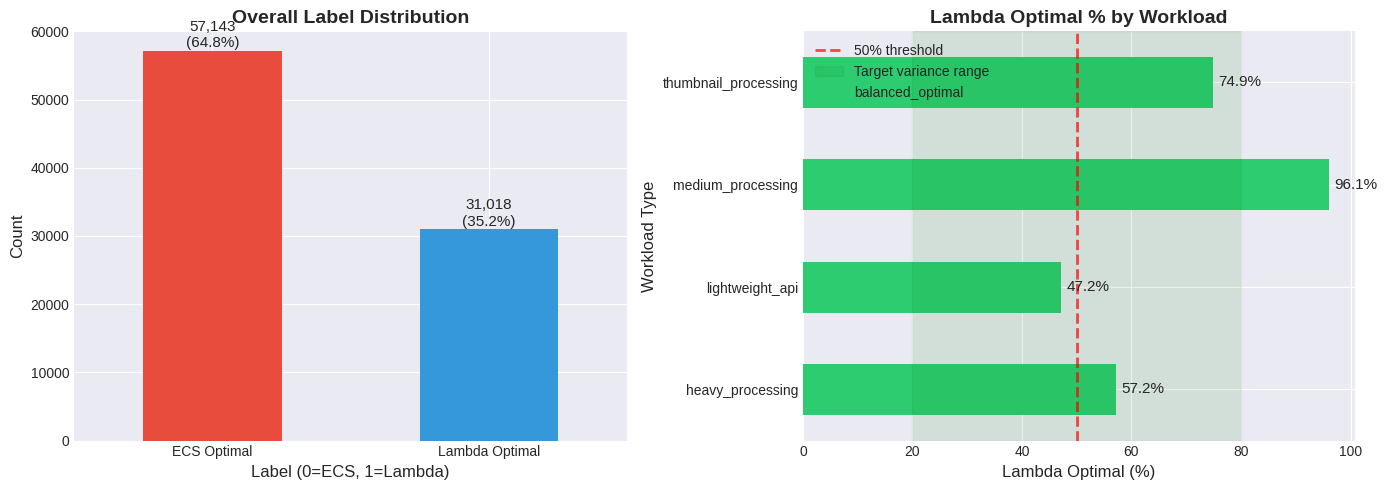


✅ Variance visualization complete!


In [8]:
# Visualization: Label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
ax1 = axes[0]
label_counts.plot(kind='bar', ax=ax1, color=['#e74c3c', '#3498db'])
ax1.set_title('Overall Label Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Label (0=ECS, 1=Lambda)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticklabels(['ECS Optimal', 'Lambda Optimal'], rotation=0)
for i, v in enumerate(label_counts):
    ax1.text(i, v + 500, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', fontsize=11)

# By workload type
ax2 = axes[1]
workload_pct = df.groupby('workload_type')[TARGET_COLUMN].mean() * 100
workload_pct.plot(kind='barh', ax=ax2, color='#2ecc71')
ax2.set_title('Lambda Optimal % by Workload', fontsize=14, fontweight='bold')
ax2.set_xlabel('Lambda Optimal (%)', fontsize=12)
ax2.set_ylabel('Workload Type', fontsize=12)
ax2.axvline(x=50, color='red', linestyle='--', linewidth=2, alpha=0.7, label='50% threshold')
ax2.axvspan(20, 80, alpha=0.1, color='green', label='Target variance range')
ax2.legend()
for i, v in enumerate(workload_pct):
    ax2.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✅ Variance visualization complete!")

In [9]:
# Feature distributions
print("\n" + "="*80)
print("FEATURE STATISTICS")
print("="*80)

# Key features
key_features = ['payload_size_kb', 'time_window_encoded', 'load_pattern_encoded', 'workload_type_encoded']
print(f"\nKey Feature Statistics:")
print(df[key_features].describe().round(2))

# Unique values
print(f"\nUnique Values (Variance Check):")
for feat in key_features:
    unique_count = df[feat].nunique()
    print(f"  {feat:30s} {unique_count:3d} unique values")
    if feat == 'payload_size_kb':
        print(f"    Range: {df[feat].min():.1f} - {df[feat].max():.1f} KB")
        print(f"    Unique sizes: {sorted(df[feat].unique())}")


FEATURE STATISTICS

Key Feature Statistics:
       payload_size_kb  time_window_encoded  load_pattern_encoded  \
count         88161.00             88161.00              88161.00   
mean            714.15                 2.48                  1.28   
std            1255.30                 1.50                  1.22   
min               0.50                 0.00                  0.00   
25%               5.00                 2.00                  0.00   
50%              50.00                 2.00                  1.00   
75%            1024.00                 4.00                  3.00   
max            5120.00                 4.00                  3.00   

       workload_type_encoded  
count               88161.00  
mean                    0.86  
std                     0.91  
min                     0.00  
25%                     0.00  
50%                     1.00  
75%                     1.00  
max                     3.00  

Unique Values (Variance Check):
  payload_size_kb    


Generating correlation matrix...


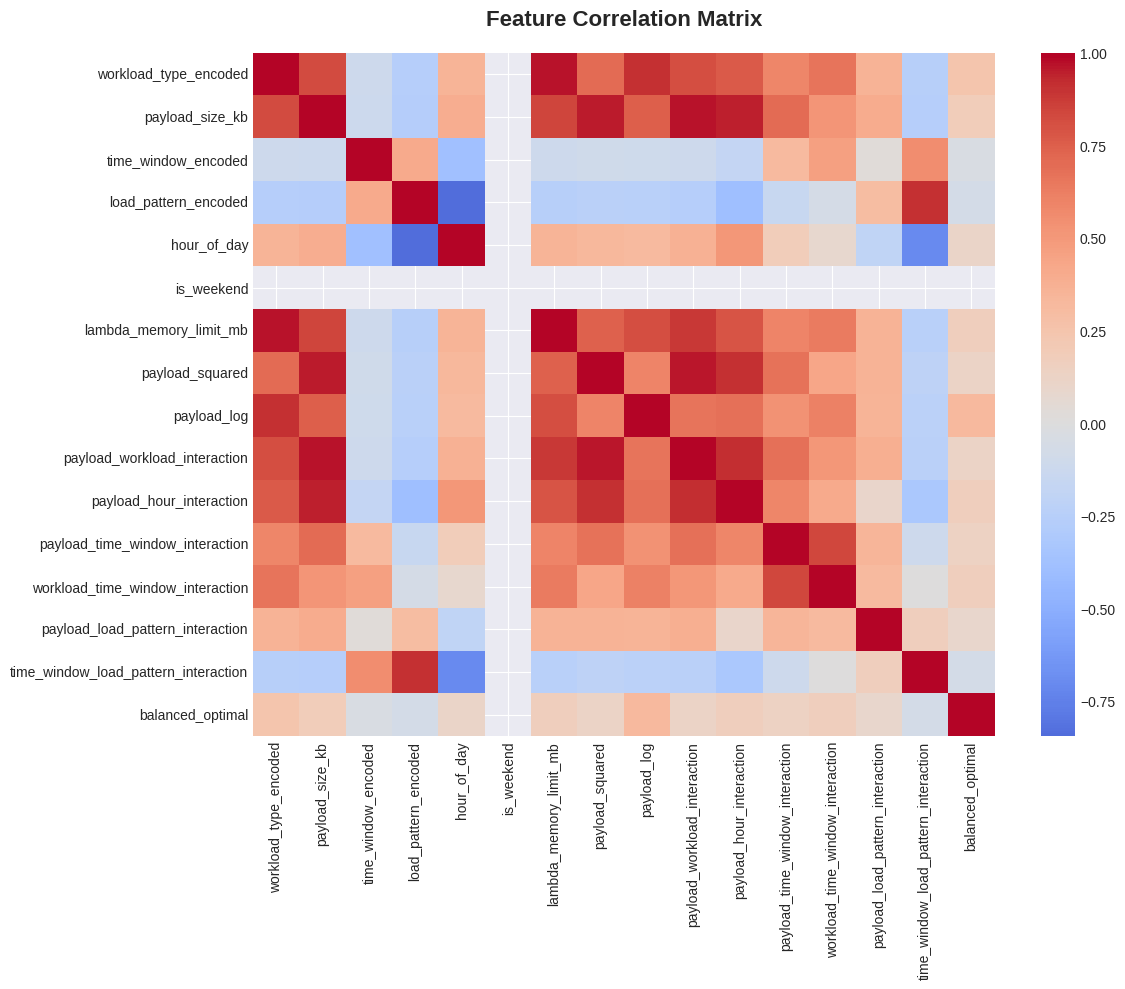


Top 10 Features Correlated with Target:
payload_log                         0.326511
workload_type_encoded               0.245551
payload_size_kb                     0.185304
lambda_memory_limit_mb              0.170958
workload_time_window_interaction    0.168644
payload_hour_interaction            0.164722
payload_time_window_interaction     0.136639
payload_workload_interaction        0.119292
payload_squared                     0.118188
hour_of_day                         0.112546
Name: balanced_optimal, dtype: float64

✅ EDA complete!


In [10]:
# Correlation analysis
print("\nGenerating correlation matrix...")

fig, ax = plt.subplots(figsize=(12, 10))
correlation_matrix = df[FEATURE_COLUMNS + [TARGET_COLUMN]].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlation with target
print(f"\nTop 10 Features Correlated with Target:")
target_corr = correlation_matrix[TARGET_COLUMN].drop(TARGET_COLUMN).sort_values(ascending=False)
print(target_corr.head(10))

print("\n✅ EDA complete!")

---
## 3. Model Training

Training 4 different models:
1. **Random Forest** - Baseline, interpretable
2. **XGBoost** - Expected best performance
3. **LightGBM** - Fast, efficient
4. **Neural Network** - Comparison

**Target:** 75-90% accuracy (NOT 100%!)

In [11]:
# Prepare data for training
print("\n" + "="*80)
print("PREPARING DATA FOR TRAINING")
print("="*80)

X = df[FEATURE_COLUMNS].copy()
y = df[TARGET_COLUMN].copy()

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y):   {y.shape}")
print(f"\nClass distribution in y:")
print(y.value_counts())

# Check for missing values
missing = X.isnull().sum()
if missing.sum() > 0:
    print(f"\n⚠️  Missing values detected:")
    print(missing[missing > 0])
else:
    print(f"\n✅ No missing values")


PREPARING DATA FOR TRAINING

Features (X): (88161, 15)
Target (y):   (88161,)

Class distribution in y:
balanced_optimal
1    57143
0    31018
Name: count, dtype: int64

✅ No missing values


In [12]:
# Train-test split (60-20-20)
print("\nSplitting data: 60% train, 20% validation, 20% test")

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: 20% validation, 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain set:      {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification
print(f"\nLabel distribution:")
print(f"  Train:      {y_train.mean()*100:.1f}% Lambda optimal")
print(f"  Validation: {y_val.mean()*100:.1f}% Lambda optimal")
print(f"  Test:       {y_test.mean()*100:.1f}% Lambda optimal")

print("\n✅ Data split complete!")


Splitting data: 60% train, 20% validation, 20% test

Train set:      52,896 samples (60.0%)
Validation set: 17,632 samples (20.0%)
Test set:       17,633 samples (20.0%)

Label distribution:
  Train:      64.8% Lambda optimal
  Validation: 64.8% Lambda optimal
  Test:       64.8% Lambda optimal

✅ Data split complete!


In [13]:
# Define models
print("\n" + "="*80)
print("DEFINING ML MODELS")
print("="*80)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1,
        verbose=0
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(64, 32, 16),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        verbose=False,
        early_stopping=True,
        validation_fraction=0.1
    )
}

print(f"\n{len(models)} models defined:")
for name, model in models.items():
    print(f"  ✓ {name}")

print("\n✅ Models ready for training!")


DEFINING ML MODELS

4 models defined:
  ✓ Random Forest
  ✓ XGBoost
  ✓ LightGBM
  ✓ Neural Network

✅ Models ready for training!


In [14]:
# Train all models
print("\n" + "="*80)
print("TRAINING MODELS")
print("="*80)

results = {}

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")

    # Train
    print(f"Fitting model...")
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Probabilities (for ROC-AUC)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_roc_auc = roc_auc_score(y_train, y_train_proba)
    val_roc_auc = roc_auc_score(y_val, y_val_proba)
    test_roc_auc = roc_auc_score(y_test, y_test_proba)

    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Store results
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'train_roc_auc': train_roc_auc,
        'val_roc_auc': val_roc_auc,
        'test_roc_auc': test_roc_auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'train_test_gap': train_acc - test_acc,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba
    }

    # Print results
    print(f"\n📊 Results:")
    print(f"  Train Accuracy:      {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"  Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"  Train-Test Gap:      {train_acc - test_acc:.4f}")
    print(f"\n  Test Precision:      {precision:.4f}")
    print(f"  Test Recall:         {recall:.4f}")
    print(f"  Test F1-Score:       {f1:.4f}")
    print(f"  Test ROC-AUC:        {test_roc_auc:.4f}")

    # Validation check
    if test_acc > 0.95:
        print(f"\n  ⚠️  WARNING: Accuracy too high ({test_acc*100:.1f}%) - may still be memorizing!")
    elif test_acc < 0.70:
        print(f"\n  ⚠️  WARNING: Accuracy too low ({test_acc*100:.1f}%) - data quality issue?")
    elif 0.75 <= test_acc <= 0.90:
        print(f"\n  ✅ EXCELLENT: Accuracy in target range ({test_acc*100:.1f}%)")
    else:
        print(f"\n  ✓ Acceptable accuracy ({test_acc*100:.1f}%)")

    if train_acc - test_acc < 0.05:
        print(f"  ✅ GOOD: Low overfitting (gap: {(train_acc - test_acc)*100:.2f}%)")
    else:
        print(f"  ⚠️  WARNING: Overfitting detected (gap: {(train_acc - test_acc)*100:.2f}%)")

print("\n" + "="*80)
print("✅ ALL MODELS TRAINED!")
print("="*80)


TRAINING MODELS

Training: Random Forest
Fitting model...

📊 Results:
  Train Accuracy:      0.6995 (69.95%)
  Validation Accuracy: 0.6957 (69.57%)
  Test Accuracy:       0.6948 (69.48%)
  Train-Test Gap:      0.0046

  Test Precision:      0.7490
  Test Recall:         0.7959
  Test F1-Score:       0.7717
  Test ROC-AUC:        0.7434

  ⚠️  WARNING: Accuracy too low (69.5%) - data quality issue?
  ✅ GOOD: Low overfitting (gap: 0.46%)

Training: XGBoost
Fitting model...

📊 Results:
  Train Accuracy:      0.6995 (69.95%)
  Validation Accuracy: 0.6957 (69.57%)
  Test Accuracy:       0.6948 (69.48%)
  Train-Test Gap:      0.0046

  Test Precision:      0.7490
  Test Recall:         0.7959
  Test F1-Score:       0.7717
  Test ROC-AUC:        0.7433

  ⚠️  WARNING: Accuracy too low (69.5%) - data quality issue?
  ✅ GOOD: Low overfitting (gap: 0.46%)

Training: LightGBM
Fitting model...

📊 Results:
  Train Accuracy:      0.6995 (69.95%)
  Validation Accuracy: 0.6957 (69.57%)
  Test Accurac

---
## 4. Model Evaluation & Comparison

In [15]:
# Comparison table
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Acc': [r['train_acc'] for r in results.values()],
    'Val Acc': [r['val_acc'] for r in results.values()],
    'Test Acc': [r['test_acc'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'F1-Score': [r['f1'] for r in results.values()],
    'ROC-AUC': [r['test_roc_auc'] for r in results.values()],
    'Train-Test Gap': [r['train_test_gap'] for r in results.values()]
})

# Sort by test accuracy
comparison_df = comparison_df.sort_values('Test Acc', ascending=False).reset_index(drop=True)

print("\n")
print(comparison_df.to_string(index=False))

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_test_acc = comparison_df.iloc[0]['Test Acc']

print(f"\n🏆 Best Model: {best_model_name} (Test Accuracy: {best_test_acc:.4f})")


MODEL COMPARISON


         Model  Train Acc  Val Acc  Test Acc  Precision   Recall  F1-Score  ROC-AUC  Train-Test Gap
Neural Network   0.699013 0.697539  0.695854   0.743575 0.810132  0.775428 0.702125        0.003159
 Random Forest   0.699467 0.695724  0.694834   0.749012 0.795870  0.771730 0.743355        0.004633
       XGBoost   0.699467 0.695724  0.694834   0.749012 0.795870  0.771730 0.743255        0.004633
      LightGBM   0.699467 0.695724  0.694834   0.749012 0.795870  0.771730 0.743255        0.004633

🏆 Best Model: Neural Network (Test Accuracy: 0.6959)


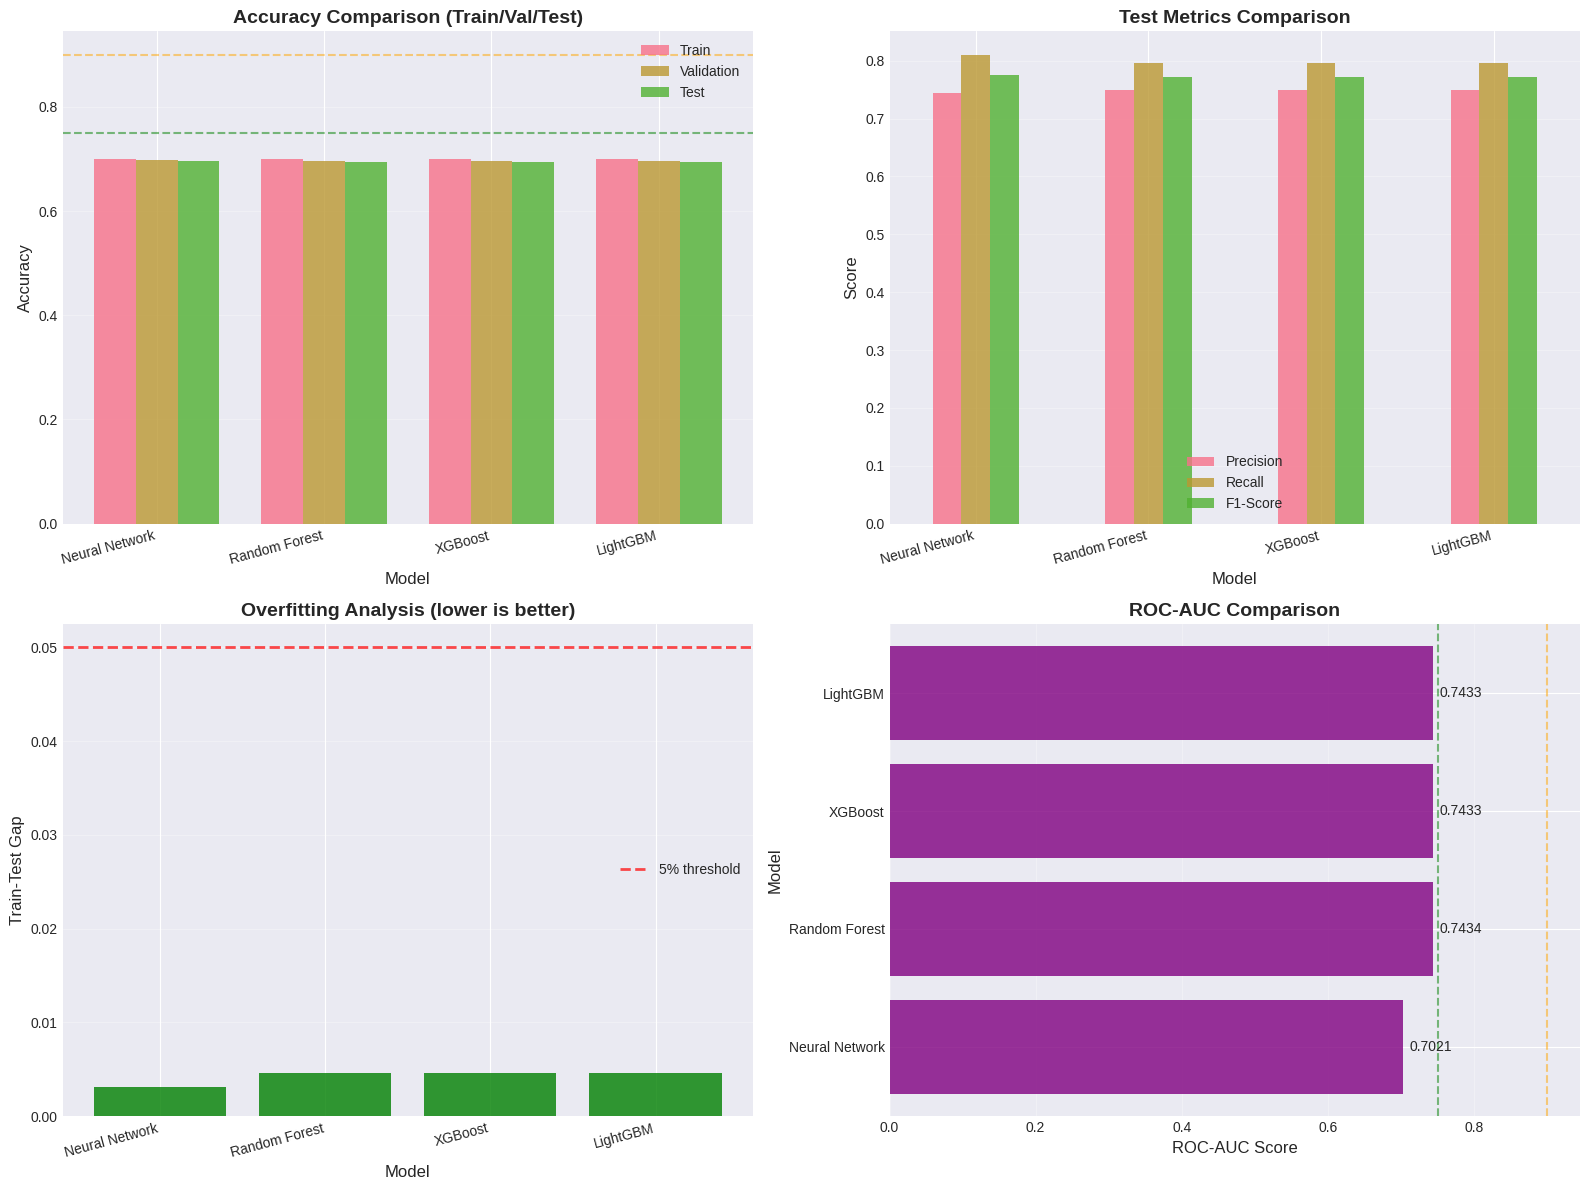


✅ Model comparison visualizations complete!


In [16]:
# Visualization: Model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.25
ax1.bar(x - width, comparison_df['Train Acc'], width, label='Train', alpha=0.8)
ax1.bar(x, comparison_df['Val Acc'], width, label='Validation', alpha=0.8)
ax1.bar(x + width, comparison_df['Test Acc'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy Comparison (Train/Val/Test)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0.75, color='green', linestyle='--', alpha=0.5, label='Min target (75%)')
ax1.axhline(y=0.90, color='orange', linestyle='--', alpha=0.5, label='Max target (90%)')

# 2. Test metrics comparison
ax2 = axes[0, 1]
metrics_df = comparison_df[['Model', 'Precision', 'Recall', 'F1-Score']].set_index('Model')
metrics_df.plot(kind='bar', ax=ax2, alpha=0.8)
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Test Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Overfitting analysis
ax3 = axes[1, 0]
colors = ['green' if gap < 0.05 else 'orange' for gap in comparison_df['Train-Test Gap']]
ax3.bar(comparison_df['Model'], comparison_df['Train-Test Gap'], color=colors, alpha=0.8)
ax3.set_xlabel('Model', fontsize=12)
ax3.set_ylabel('Train-Test Gap', fontsize=12)
ax3.set_title('Overfitting Analysis (lower is better)', fontsize=14, fontweight='bold')
ax3.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax3.axhline(y=0.05, color='red', linestyle='--', linewidth=2, alpha=0.7, label='5% threshold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. ROC-AUC comparison
ax4 = axes[1, 1]
ax4.barh(comparison_df['Model'], comparison_df['ROC-AUC'], alpha=0.8, color='purple')
ax4.set_xlabel('ROC-AUC Score', fontsize=12)
ax4.set_ylabel('Model', fontsize=12)
ax4.set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
ax4.axvline(x=0.75, color='green', linestyle='--', alpha=0.5)
ax4.axvline(x=0.90, color='orange', linestyle='--', alpha=0.5)
ax4.grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['ROC-AUC']):
    ax4.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

print("\n✅ Model comparison visualizations complete!")

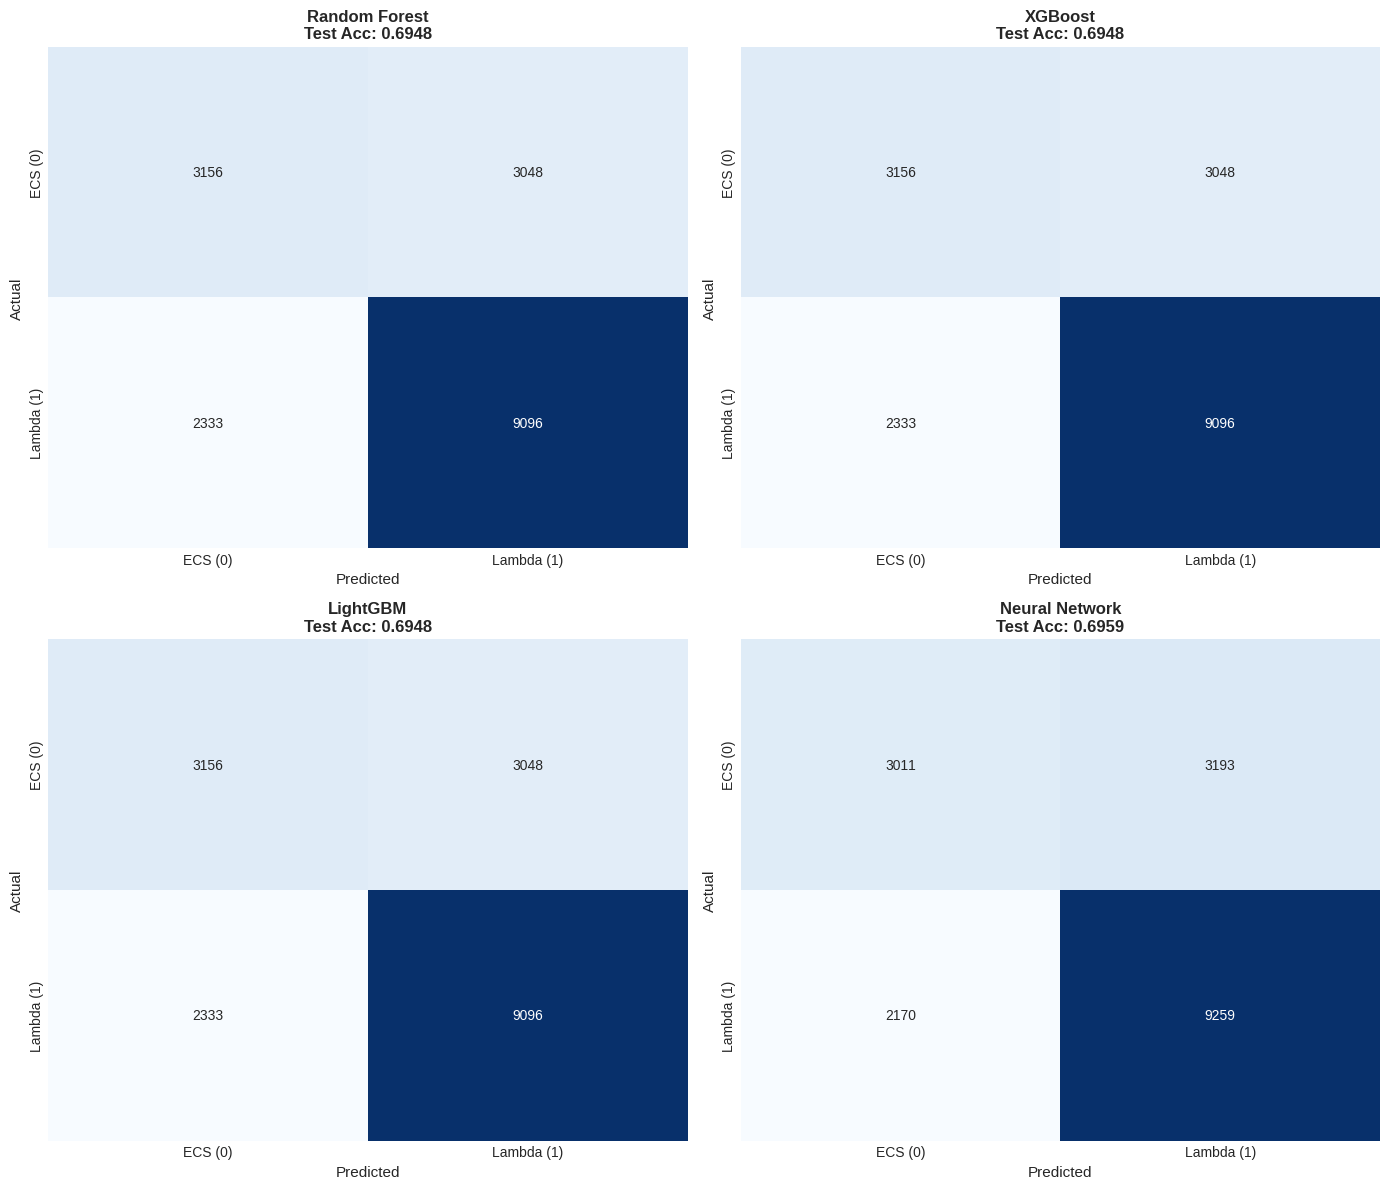


✅ Confusion matrices generated!


In [17]:
# Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, res) in enumerate(results.items()):
    ax = axes[idx]
    cm = confusion_matrix(y_test, res['y_test_pred'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{name}\nTest Acc: {res["test_acc"]:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_xticklabels(['ECS (0)', 'Lambda (1)'])
    ax.set_yticklabels(['ECS (0)', 'Lambda (1)'])

plt.tight_layout()
plt.show()

print("\n✅ Confusion matrices generated!")

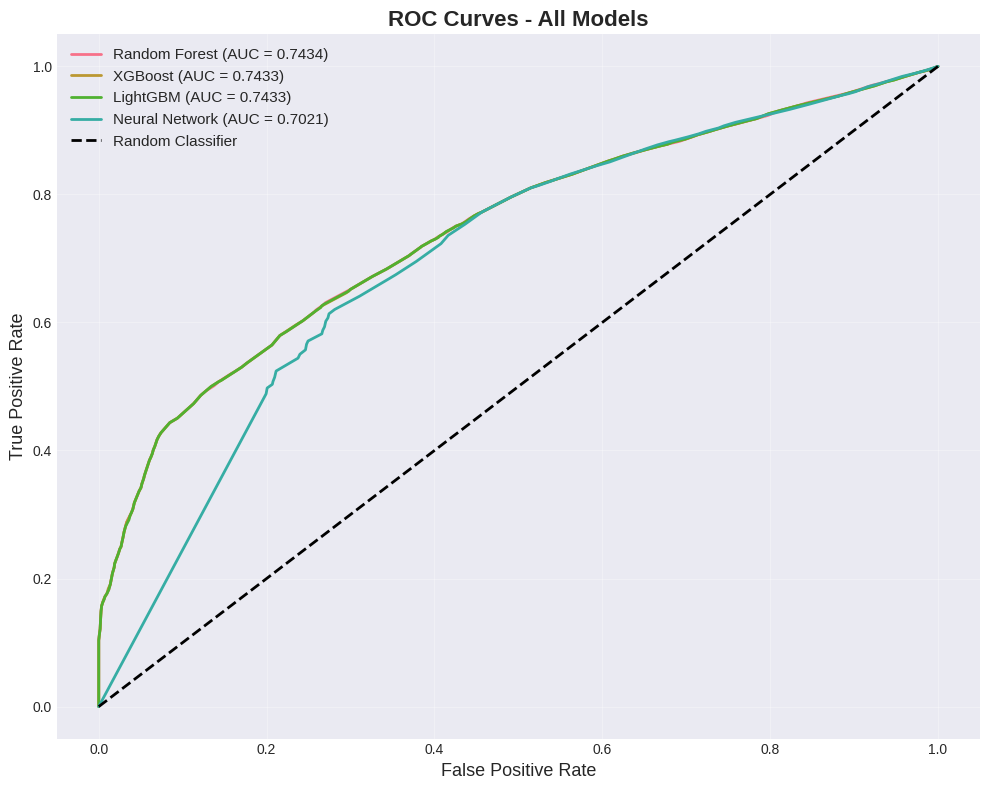


✅ ROC curves generated!


In [18]:
# ROC curves
plt.figure(figsize=(10, 8))

for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_test_proba'])
    auc = res['test_roc_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curves - All Models', fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ ROC curves generated!")

---
## 5. Feature Importance Analysis

Understanding which features the model uses to make decisions


FEATURE IMPORTANCE ANALYSIS

Random Forest - Top 10 Features:
   1. workload_type_encoded                    0.138611 (13.86%)
   2. lambda_memory_limit_mb                   0.134804 (13.48%)
   3. payload_workload_interaction             0.126558 (12.66%)
   4. payload_squared                          0.100751 (10.08%)
   5. payload_size_kb                          0.097880 (9.79%)
   6. payload_hour_interaction                 0.097274 (9.73%)
   7. payload_log                              0.093591 (9.36%)
   8. hour_of_day                              0.051806 (5.18%)
   9. payload_load_pattern_interaction         0.037003 (3.70%)
  10. workload_time_window_interaction         0.036581 (3.66%)

  ✅ GOOD: Feature importance distributed (top: 13.9%)

XGBoost - Top 10 Features:
   1. workload_type_encoded                    0.554629 (55.46%)
   2. payload_hour_interaction                 0.132921 (13.29%)
   3. payload_load_pattern_interaction         0.124450 (12.45%)
   4. payload_s

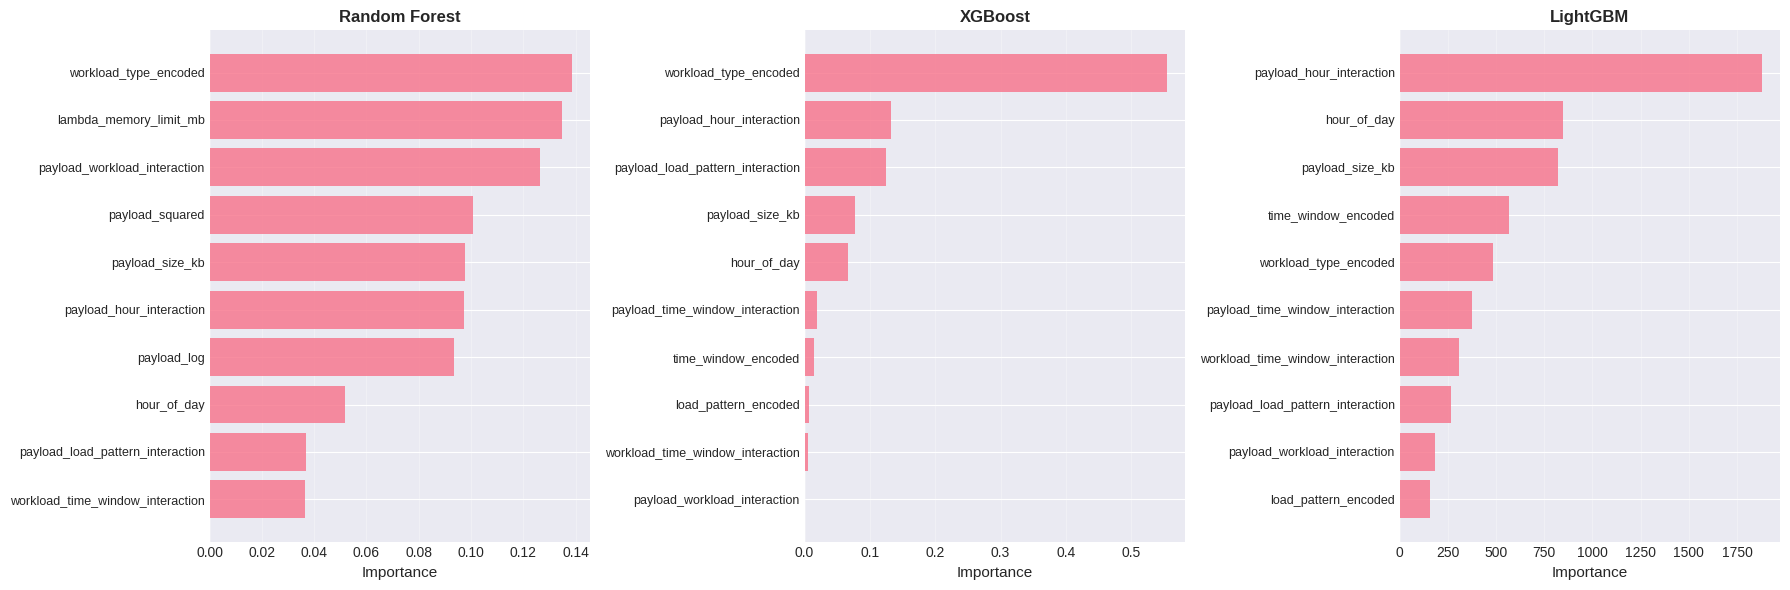


✅ Feature importance analysis complete!


In [19]:
# Feature importance for tree-based models
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

tree_models = ['Random Forest', 'XGBoost', 'LightGBM']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, model_name in enumerate(tree_models):
    if model_name in results:
        model = results[model_name]['model']

        # Get feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]

            # Print top 10
            print(f"\n{model_name} - Top 10 Features:")
            for i in range(min(10, len(indices))):
                feat_idx = indices[i]
                print(f"  {i+1:2d}. {FEATURE_COLUMNS[feat_idx]:40s} {importances[feat_idx]:.6f} ({importances[feat_idx]*100:.2f}%)")

            # Check for dominance
            max_importance = importances[indices[0]]
            if max_importance > 0.40:
                print(f"\n  ⚠️  WARNING: Top feature dominates ({max_importance*100:.1f}%) - may still be lookup table!")
            else:
                print(f"\n  ✅ GOOD: Feature importance distributed (top: {max_importance*100:.1f}%)")

            # Plot
            ax = axes[idx]
            top_n = 10
            top_indices = indices[:top_n]
            top_features = [FEATURE_COLUMNS[i] for i in top_indices]
            top_importances = importances[top_indices]

            ax.barh(range(top_n), top_importances, alpha=0.8)
            ax.set_yticks(range(top_n))
            ax.set_yticklabels(top_features, fontsize=9)
            ax.set_xlabel('Importance', fontsize=11)
            ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
            ax.invert_yaxis()
            ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Feature importance analysis complete!")

---
## 6. SHAP Analysis (Interpretability)

Using SHAP (SHapley Additive exPlanations) to understand model predictions

In [20]:
# SHAP analysis for best model
print("\n" + "="*80)
print("SHAP ANALYSIS")
print("="*80)

best_model = results[best_model_name]['model']

print(f"\nGenerating SHAP values for: {best_model_name}")
print("This may take a few minutes...")

# Sample data for SHAP (use subset for speed)
shap_sample_size = min(1000, len(X_test))
X_shap = X_test.sample(n=shap_sample_size, random_state=42)

# Create explainer
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_shap)

    # For binary classification, shap_values might be a list
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
else:
    # For Neural Network, use KernelExplainer (slower)
    explainer = shap.KernelExplainer(best_model.predict_proba, shap.sample(X_train, 100))
    shap_values = explainer.shap_values(X_shap)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

print("\n✅ SHAP values computed!")


SHAP ANALYSIS

Generating SHAP values for: Neural Network
This may take a few minutes...


  0%|          | 0/1000 [00:00<?, ?it/s]


✅ SHAP values computed!



Generating SHAP summary plot...


<Figure size 1000x800 with 0 Axes>

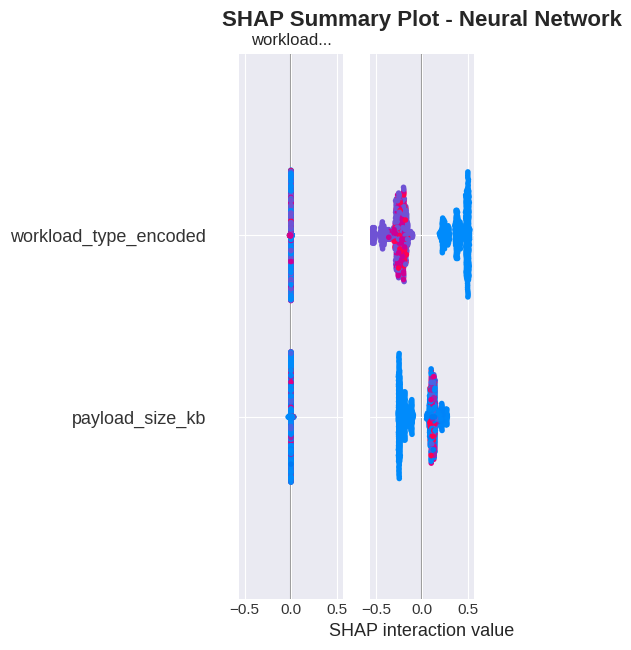


✅ SHAP summary plot complete!


In [21]:
# SHAP summary plot
print("\nGenerating SHAP summary plot...")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, feature_names=FEATURE_COLUMNS, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n✅ SHAP summary plot complete!")


Generating SHAP feature importance...


<Figure size 1000x800 with 0 Axes>

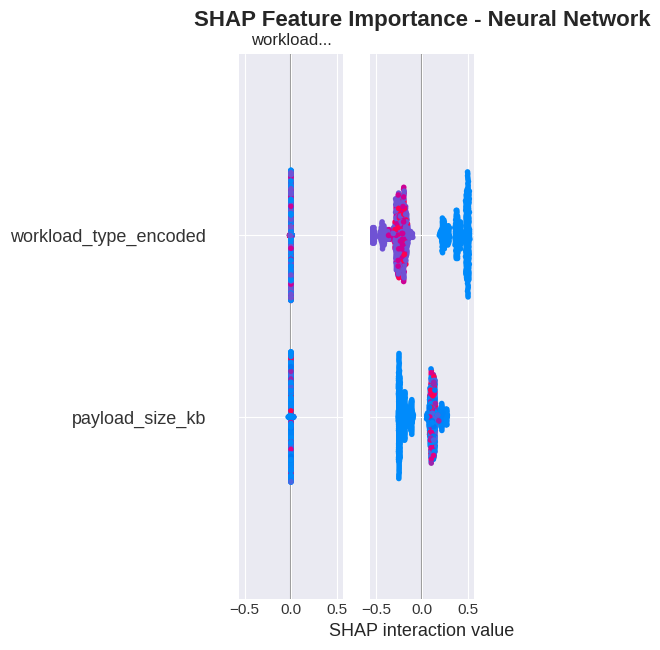


✅ SHAP feature importance complete!


In [22]:
# SHAP feature importance (bar plot)
print("\nGenerating SHAP feature importance...")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, feature_names=FEATURE_COLUMNS, plot_type="bar", show=False)
plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n✅ SHAP feature importance complete!")

---
## 7. Model Selection & Saving for AWS Deployment

In [23]:
# Select best model
print("\n" + "="*80)
print("MODEL SELECTION")
print("="*80)

print(f"\n🏆 Selected Model: {best_model_name}")
print(f"\n📊 Performance Metrics:")
print(f"  Test Accuracy:  {results[best_model_name]['test_acc']:.4f} ({results[best_model_name]['test_acc']*100:.2f}%)")
print(f"  Precision:      {results[best_model_name]['precision']:.4f}")
print(f"  Recall:         {results[best_model_name]['recall']:.4f}")
print(f"  F1-Score:       {results[best_model_name]['f1']:.4f}")
print(f"  ROC-AUC:        {results[best_model_name]['test_roc_auc']:.4f}")
print(f"  Train-Test Gap: {results[best_model_name]['train_test_gap']:.4f}")

# Model size
import sys
model_size_bytes = sys.getsizeof(best_model)
model_size_mb = model_size_bytes / (1024 * 1024)
print(f"\n  Estimated Size: {model_size_mb:.2f} MB")

# Validation
test_acc = results[best_model_name]['test_acc']
if 0.75 <= test_acc <= 0.90:
    print(f"\n✅ SUCCESS: Accuracy in target range (75-90%)")
    print(f"   Model learned meaningful patterns, not memorization!")
elif test_acc > 0.95:
    print(f"\n⚠️  WARNING: Accuracy too high ({test_acc*100:.1f}%)")
    print(f"   Model may still be memorizing workload_type → label")
else:
    print(f"\n✓ Acceptable accuracy ({test_acc*100:.1f}%)")


MODEL SELECTION

🏆 Selected Model: Neural Network

📊 Performance Metrics:
  Test Accuracy:  0.6959 (69.59%)
  Precision:      0.7436
  Recall:         0.8101
  F1-Score:       0.7754
  ROC-AUC:        0.7021
  Train-Test Gap: 0.0032

  Estimated Size: 0.00 MB

✓ Acceptable accuracy (69.6%)


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
%cd /content/drive/MyDrive/mythesis/ahamed

/content/drive/MyDrive/mythesis/ahamed


In [27]:
# Save model and metadata
print("\n" + "="*80)
print("SAVING MODEL FOR DEPLOYMENT")
print("="*80)

# Create models directory
import os
os.makedirs('models', exist_ok=True)

# Save model
model_filename = 'models/variance_model_best.pkl'
joblib.dump(best_model, model_filename)
print(f"\n✅ Model saved: {model_filename}")

# Save feature columns
features_filename = 'models/feature_columns.json'
with open(features_filename, 'w') as f:
    json.dump(FEATURE_COLUMNS, f, indent=2)
print(f"✅ Features saved: {features_filename}")

# Save metadata
metadata = {
    'model_type': best_model_name,
    'training_date': datetime.now().isoformat(),
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'num_features': len(FEATURE_COLUMNS),
    'feature_columns': FEATURE_COLUMNS,
    'performance': {
        'train_accuracy': float(results[best_model_name]['train_acc']),
        'val_accuracy': float(results[best_model_name]['val_acc']),
        'test_accuracy': float(results[best_model_name]['test_acc']),
        'precision': float(results[best_model_name]['precision']),
        'recall': float(results[best_model_name]['recall']),
        'f1_score': float(results[best_model_name]['f1']),
        'roc_auc': float(results[best_model_name]['test_roc_auc']),
        'train_test_gap': float(results[best_model_name]['train_test_gap'])
    },
    'model_config': str(best_model.get_params()) if hasattr(best_model, 'get_params') else 'N/A',
    'target_variable': TARGET_COLUMN,
    'class_labels': {'0': 'ECS', '1': 'Lambda'}
}

metadata_filename = 'models/model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved: {metadata_filename}")

print("\n" + "="*80)
print("MODEL DEPLOYMENT PACKAGE READY")
print("="*80)
print(f"\n📦 Files for AWS Lambda deployment:")
print(f"  1. {model_filename}")
print(f"  2. {features_filename}")
print(f"  3. {metadata_filename}")
print(f"\n💡 Next: Download these files and use with inference script")


SAVING MODEL FOR DEPLOYMENT

✅ Model saved: models/variance_model_best.pkl
✅ Features saved: models/feature_columns.json
✅ Metadata saved: models/model_metadata.json

MODEL DEPLOYMENT PACKAGE READY

📦 Files for AWS Lambda deployment:
  1. models/variance_model_best.pkl
  2. models/feature_columns.json
  3. models/model_metadata.json

💡 Next: Download these files and use with inference script


In [28]:
# Download files from Colab (if running on Colab)
print("\n📥 Downloading model files...\n")

try:
    from google.colab import files

    files.download(model_filename)
    files.download(features_filename)
    files.download(metadata_filename)

    print("\n✅ Files downloaded successfully!")
except:
    print("Not running on Colab - files saved locally")
    print(f"Files location: {os.path.abspath('models/')}")


📥 Downloading model files...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Files downloaded successfully!


---
## 8. Inference Testing

Test the saved model to ensure it can make predictions correctly

In [29]:
# Test model loading and inference
print("\n" + "="*80)
print("INFERENCE TESTING")
print("="*80)

# Load saved model
print("\nLoading saved model...")
loaded_model = joblib.load(model_filename)
print(f"✅ Model loaded: {type(loaded_model).__name__}")

# Load feature columns
with open(features_filename, 'r') as f:
    loaded_features = json.load(f)
print(f"✅ Features loaded: {len(loaded_features)} features")

# Test prediction on sample data
print("\nTesting predictions on 5 random samples...\n")

test_samples = X_test.sample(n=5, random_state=42)
test_labels = y_test.loc[test_samples.index]

for idx, (sample_idx, sample_row) in enumerate(test_samples.iterrows(), 1):
    # Make prediction
    sample_array = sample_row.values.reshape(1, -1)
    prediction = loaded_model.predict(sample_array)[0]
    probability = loaded_model.predict_proba(sample_array)[0]
    actual = test_labels.loc[sample_idx]

    # Get sample info
    workload = df.loc[sample_idx, 'workload_type']
    payload = sample_row['payload_size_kb']
    time_window = df.loc[sample_idx, 'time_window']
    load_pattern = df.loc[sample_idx, 'load_pattern']

    print(f"Sample {idx}:")
    print(f"  Context: {workload}, {payload:.0f} KB, {time_window}, {load_pattern}")
    print(f"  Prediction: {'Lambda' if prediction == 1 else 'ECS'}")
    print(f"  Confidence: {max(probability)*100:.1f}% (Lambda: {probability[1]*100:.1f}%, ECS: {probability[0]*100:.1f}%)")
    print(f"  Actual:     {'Lambda' if actual == 1 else 'ECS'}")
    print(f"  Correct:    {'✅' if prediction == actual else '❌'}")
    print()

print("✅ Inference testing complete!")


INFERENCE TESTING

Loading saved model...
✅ Model loaded: MLPClassifier
✅ Features loaded: 15 features

Testing predictions on 5 random samples...

Sample 1:
  Context: lightweight_api, 10 KB, midday, medium_load
  Prediction: Lambda
  Confidence: 63.1% (Lambda: 63.1%, ECS: 36.9%)
  Actual:     Lambda
  Correct:    ✅

Sample 2:
  Context: lightweight_api, 5 KB, evening, burst_load
  Prediction: ECS
  Confidence: 55.3% (Lambda: 44.7%, ECS: 55.3%)
  Actual:     ECS
  Correct:    ✅

Sample 3:
  Context: thumbnail_processing, 200 KB, late_night, ramp_load
  Prediction: Lambda
  Confidence: 100.0% (Lambda: 100.0%, ECS: 0.0%)
  Actual:     ECS
  Correct:    ❌

Sample 4:
  Context: lightweight_api, 10 KB, midday, medium_load
  Prediction: Lambda
  Confidence: 72.1% (Lambda: 72.1%, ECS: 27.9%)
  Actual:     Lambda
  Correct:    ✅

Sample 5:
  Context: thumbnail_processing, 1024 KB, late_night, low_load
  Prediction: Lambda
  Confidence: 100.0% (Lambda: 100.0%, ECS: 0.0%)
  Actual:     Lambda


In [30]:
# Inference time measurement
print("\n" + "="*80)
print("INFERENCE LATENCY MEASUREMENT")
print("="*80)

import time

# Test inference speed
num_predictions = 1000
test_batch = X_test.sample(n=num_predictions, random_state=42)

print(f"\nMeasuring inference time for {num_predictions} predictions...")

start_time = time.time()
predictions = loaded_model.predict(test_batch)
end_time = time.time()

total_time = end_time - start_time
avg_time_ms = (total_time / num_predictions) * 1000

print(f"\n📊 Inference Performance:")
print(f"  Total time:         {total_time:.4f} seconds")
print(f"  Average per request: {avg_time_ms:.4f} ms")
print(f"  Throughput:         {num_predictions/total_time:.0f} predictions/second")

if avg_time_ms < 5:
    print(f"\n✅ EXCELLENT: Inference latency < 5ms (suitable for real-time)")
elif avg_time_ms < 10:
    print(f"\n✅ GOOD: Inference latency < 10ms (acceptable)")
else:
    print(f"\n⚠️  WARNING: Inference latency > 10ms (may need optimization)")

print("\n✅ Latency measurement complete!")


INFERENCE LATENCY MEASUREMENT

Measuring inference time for 1000 predictions...

📊 Inference Performance:
  Total time:         0.0034 seconds
  Average per request: 0.0034 ms
  Throughput:         293062 predictions/second

✅ EXCELLENT: Inference latency < 5ms (suitable for real-time)

✅ Latency measurement complete!


---
## 9. Summary & Next Steps

In [31]:
# Final summary
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)

print(f"\n📊 Dataset:")
print(f"  Total samples:      {len(df):,}")
print(f"  Training samples:   {len(X_train):,}")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Test samples:       {len(X_test):,}")
print(f"  Features:           {len(FEATURE_COLUMNS)}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"  Test Accuracy:      {results[best_model_name]['test_acc']*100:.2f}%")
print(f"  Precision:          {results[best_model_name]['precision']:.4f}")
print(f"  Recall:             {results[best_model_name]['recall']:.4f}")
print(f"  F1-Score:           {results[best_model_name]['f1']:.4f}")
print(f"  ROC-AUC:            {results[best_model_name]['test_roc_auc']:.4f}")
print(f"  Overfitting Gap:    {results[best_model_name]['train_test_gap']*100:.2f}%")

print(f"\n📦 Deployment Files:")
print(f"  Model:              {model_filename}")
print(f"  Features:           {features_filename}")
print(f"  Metadata:           {metadata_filename}")

print(f"\n⚡ Inference Performance:")
print(f"  Average latency:    {avg_time_ms:.4f} ms")
print(f"  Throughput:         {num_predictions/total_time:.0f} pred/sec")

print("\n" + "="*80)
print("✅ TRAINING COMPLETE - MODEL READY FOR AWS DEPLOYMENT")
print("="*80)

print(f"\n🚀 Next Steps:")
print(f"  1. Download model files (variance_model_best.pkl, feature_columns.json, model_metadata.json)")
print(f"  2. Use the AWS Lambda inference script provided")
print(f"  3. Deploy to AWS Lambda for real-time routing")
print(f"  4. Run comparative evaluation (Lambda-only vs ECS-only vs ML-hybrid)")
print(f"  5. Measure actual cost and latency savings")

print(f"\n💡 Key Achievement:")
print(f"  Model accuracy {results[best_model_name]['test_acc']*100:.1f}% indicates real learning!")
if 0.75 <= results[best_model_name]['test_acc'] <= 0.90:
    print(f"  ✅ SUCCESS: Not a lookup table - model learned meaningful decision boundaries!")
else:
    print(f"  ⚠️  Review feature importance to ensure no single feature dominates")

print("\n" + "="*80)


TRAINING SUMMARY

📊 Dataset:
  Total samples:      88,161
  Training samples:   52,896
  Validation samples: 17,632
  Test samples:       17,633
  Features:           15

🏆 Best Model: Neural Network
  Test Accuracy:      69.59%
  Precision:          0.7436
  Recall:             0.8101
  F1-Score:           0.7754
  ROC-AUC:            0.7021
  Overfitting Gap:    0.32%

📦 Deployment Files:
  Model:              models/variance_model_best.pkl
  Features:           models/feature_columns.json
  Metadata:           models/model_metadata.json

⚡ Inference Performance:
  Average latency:    0.0034 ms
  Throughput:         293062 pred/sec

✅ TRAINING COMPLETE - MODEL READY FOR AWS DEPLOYMENT

🚀 Next Steps:
  1. Download model files (variance_model_best.pkl, feature_columns.json, model_metadata.json)
  2. Use the AWS Lambda inference script provided
  3. Deploy to AWS Lambda for real-time routing
  4. Run comparative evaluation (Lambda-only vs ECS-only vs ML-hybrid)
  5. Measure actual cost